In [1]:
#Importación de librearías necesarias
import pandas as pd
from datetime import datetime
import socket
import numpy as np
import math
import time
import pickle  #Para guardar archivos
import os
os.environ['OMP_NUM_THREADS'] = '1'

from pympler import asizeof #Para liberar memoria
import gc

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
import kneed
import random

from sklearn.preprocessing import StandardScaler

from collections import Counter

# semilla = 8

In [2]:
#Path general de archivos
if socket.gethostname()=='LAPTOP-PUSGG08B': #Ip de la laptop
    ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/Data/TFM/"
    r_ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/RData/TFM/"
    r_graf = 'E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/Reportes/'
elif socket.gethostname()=='PCUIOMTDAIE6382': #Ip del working
    ruta =   "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/Data/TFM/"
    r_ruta = "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/RData/TFM/"
    r_graf = 'D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/Reportes/'
# Ruta del archivo de pensionistas de vejez
ruta_vj = ruta + 'POB_VEJ_CD656_NEW.dsv'
# Ruta del archivo de historia laboral de pensionistas
ruta_afi = ruta + 'APORTES_CD656_new.dsv'

directorio = r_ruta

In [3]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
data_l = pd.read_pickle(ruta_archivo)

In [ ]:
data_l.shape #(62130167, 16)

In [ ]:
inicio = time.time()
data_l = data_l.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[ True, True, True] )
data_l.reset_index(inplace=True)
data_l.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_l.drop(columns=['nuevo_indice'], inplace=True)
data_l['INDICE'] = data_l.index

#Casos de no análisis
data_no_grupo = data_l[ (data_l['GRUPO_SEL']==0) ].copy()
data_no_grupo['CLA_KM_M1'] = np.nan
data_no_grupo['CLA_KM_M2'] = np.nan
data_no_grupo['CLA_KM_MS2'] = np.nan
data_no_grupo['CLA_KM_M3'] = np.nan
data_no_grupo['CLA_KM_M4'] = np.nan
data_no_grupo['CLA_KM_MS4'] = np.nan

data_no_grupo['ATI_KM_M1'] = np.nan
data_no_grupo['ATI_KM_M2'] = np.nan 
data_no_grupo['ATI_KM_MS2'] = np.nan 
data_no_grupo['ATI_KM_M3'] = np.nan
data_no_grupo['ATI_KM_M4'] = np.nan
data_no_grupo['ATI_KM_MS4'] = np.nan 

data_no_grupo['NUM_CODO_M1'] = np.nan
data_no_grupo['NUM_CODO_M2'] = np.nan
data_no_grupo['NUM_CODO_M3'] = np.nan
data_no_grupo['NUM_CODO_M4'] = np.nan 

data_no_grupo['NUM_SILU_M1'] = np.nan
data_no_grupo['NUM_SILU_M2'] = np.nan
data_no_grupo['NUM_SILU_M3'] = np.nan
data_no_grupo['NUM_SILU_M4'] = np.nan

data_no_grupo['CEN1_M1'] = np.nan
data_no_grupo['CEN1_M2'] = np.nan
data_no_grupo['CEN1_M3'] = np.nan
data_no_grupo['CEN1_M4'] = np.nan

data_no_grupo['CEN2_M1'] = np.nan
data_no_grupo['CEN2_M2'] = np.nan
data_no_grupo['CEN2_M3'] = np.nan
data_no_grupo['CEN2_M4'] = np.nan

data_no_grupo['LS_M1'] = np.nan
data_no_grupo['LS_M2'] = np.nan
data_no_grupo['LS_M3'] = np.nan
data_no_grupo['LS_M4'] = np.nan

#Casos de análisis
data = data_l[ (data_l['GRUPO_SEL']==1) ].copy()

fin = time.time()  
tm = fin-inicio
print('Tiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60, 'segundos' )

In [ ]:
#Se calculo los bigotes superiores para toda la historia laboral
inicio = time.time() 
dataa = data_l.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['SAL_PROM1'] =  np.nanmean(salarios)
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': [], 'SAL_PROM1': [] }

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )
    data1['SAL_PROM1'].append( val['SAL_PROM1'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[:, 'LS1'] = data_l['CEDULA_COD'].map(LS)

SPROM = pd.DataFrame( data1 )
SPROM = SPROM.groupby('CEDULA_COD')['SAL_PROM1'].first()
data_l.loc[:, 'SAL_PROM1'] = data_l['CEDULA_COD'].map(SPROM)

del dataa, data1, dic_aux, LS, salarios, SPROM
gc.collect()

##Se calculo los bigotes superiores para toda la historia laboral, a partir del año 2000 en adelante.
dataa = data_l[data_l['ANIO']>=2000].copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['SAL_PROM2'] =  np.nanmean(salarios)
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': [], 'SAL_PROM2': []  }

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )
    data1['SAL_PROM2'].append( val['SAL_PROM2'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[:, 'LS2'] = data_l['CEDULA_COD'].map(LS)

SPROM = pd.DataFrame( data1 )
SPROM = SPROM.groupby('CEDULA_COD')['SAL_PROM2'].first()
data_l.loc[:, 'SAL_PROM2'] = data_l['CEDULA_COD'].map(SPROM)

del dataa, data1, dic_aux, LS, salarios, SPROM
gc.collect()

fin = time.time() 
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos')

In [ ]:
data_l # cedulas unicas 442570

In [ ]:
data['CEDULA_COD'].nunique() #442570

In [ ]:
#Algortimos K-means
inicio = time.time() 

cedula_1 = data.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
cedula_dist = cedula_1[ cedula_1 ].index
ul = data[ ~data['CEDULA_COD'].isin( cedula_dist )]
ml = data[  data['CEDULA_COD'].isin( cedula_dist )]

fin = time.time()  
tm = fin - inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos')

del data

In [ ]:
print('Número de cédulas en ul', ul['CEDULA_COD'].nunique()) #cedulas unicas 373069
print('Número de cédulas en ml', ml['CEDULA_COD'].nunique()) #cedulas unicas 69501

In [ ]:
#Se calculo los bigotes superiores para la historia laboral de los mejores años
inicio = time.time() 
dataa = ul.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': []}

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[ ~data_l['CEDULA_COD'].isin( cedula_dist ), 'LS_MS'] = data_l['CEDULA_COD'].map(LS)

del dataa, data1, dic_aux, LS
gc.collect()

dataa = ml.copy()
dic_aux = dataa.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'INDICE': list}).to_dict(orient='index')

for cedula in dic_aux:
    dic_aux[cedula]['SALARIO_SECTOR'] = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                            if isinstance(sal, str) 
                                            else [float(sal)]
                                            for sal in dic_aux[cedula]['SALARIO_SECTOR']
                                        ]
    # Aplanar la lista de listas de SALARIO_SECTOR
    salarios = None
    salarios = [salario for sublist in dic_aux[cedula]['SALARIO_SECTOR'] for salario in sublist]
    dic_aux[cedula]['Q1'] =  np.percentile(salarios, 25)
    dic_aux[cedula]['Q3'] =  np.percentile(salarios, 75)
    dic_aux[cedula]['IQR'] = dic_aux[cedula]['Q3'] -  dic_aux[cedula]['Q1']
    dic_aux[cedula]['LI'] =  dic_aux[cedula]['Q1'] -  1.5  * dic_aux[cedula]['IQR']
    dic_aux[cedula]['LS'] =  dic_aux[cedula]['Q3'] +  1.5  * dic_aux[cedula]['IQR']

data1 = { 'CEDULA_COD': [], 'LS': []}

for cedula, val in dic_aux.items():
    data1['CEDULA_COD'].append(cedula)
    data1['LS'].append( val['LS'] )

LS = pd.DataFrame( data1 )
LS = LS.groupby('CEDULA_COD')['LS'].first()
data_l.loc[  data_l['CEDULA_COD'].isin( cedula_dist ), 'LS_MS'] = data_l['CEDULA_COD'].map(LS)

fin = time.time()  
tm = fin - inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos')

del dataa, data1, dic_aux, LS
gc.collect()

In [ ]:
#data_l[ (~data_l['CEDULA_COD'].isin( cedula_dist )) & (data_l['LS_MS'].isna()) ]
data_l[data_l['CEDULA_COD']==216]

In [ ]:
#Verificación de valores LS calculados
a = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                        if isinstance(sal, str) 
                                        else [float(sal)]
                                        for sal in data_l[ (data_l['CEDULA_COD']==216)]['SALARIO_SECTOR']
                                    ]
# Aplanar la lista de listas de SALARIO_SECTOR
salarios = None
salarios = [salario for sublist in a for salario in sublist]
salarios
print('sal promedio', np.nanmean(salarios))
q1=  np.percentile(salarios, 25)
q3 =  np.percentile(salarios, 75)
iqr = q3 -  q1
print('Ls', q3+1.5*iqr)

b = [ [float(val) for val in sal.replace(':', ';').split(';')] 
                                        if isinstance(sal, str) 
                                        else [float(sal)]
                                        for sal in ml[ (ml['CEDULA_COD']==216) ]['SALARIO_SECTOR']
                                    ]
salarios = None
salarios = [salario for sublist in b for salario in sublist]
salarios
print('sal promedio', np.nanmean(salarios))
q1=  np.percentile(salarios, 25)
q3 =  np.percentile(salarios, 75)
iqr = q3 -  q1
print('LS_MS', q3+1.5*iqr)


In [ ]:
#Determinación del número de cluster según el método del codo y Silueta
# Normalización de datos
def data_norm( df1 ):
    df = df1.copy()
    me = df.groupby('CEDULA_COD')['SALARIO'].mean()
    st = df.groupby('CEDULA_COD')['SALARIO'].std(0)
    df['ME'] = df['CEDULA_COD'].map( me )
    df['ST'] = df['CEDULA_COD'].map( st )
    df['SALARIO_NORM'] = ( df['SALARIO'] - df['ME'] ) / df['ST'] 
    return df

#Determinación del número de cluster por el método de la silueta
def max_clust_silueta( silhouettes ):
    silhouettes = np.array(silhouettes)
    diferencias = np.abs(1 - silhouettes)
    indice_cercano = np.argmin( diferencias )
    return indice_cercano + 2

#Determinar el número de cluster por el método del codo
def num_cluster( data, num, num_sample, tipo, duplicados ):
    print('*' * 102)
    print('Determinación del número de clúster por el método del codo y silueta')
    inicio = time.time()
    
    data_si_dic = data.copy()
    
    if( num_sample != 'todo' ):
        sample_size = num_sample
        sample_keys = random.sample( list(data_si_dic.keys()), min(sample_size, len(data_si_dic))) #Seleccion de cedulas
        data_filt = {key: data_si_dic[key] for key in sample_keys if key in data_si_dic}
    if (num_sample == 'todo' ):
        data_filt = data_si_dic
        
    for ced  in data_filt:
        
        if( duplicados=='si'):
            aux = np.array( data_filt[ced][ tipo ]).reshape(-1, 1)
        
        if( duplicados=='no'):
            aux = np.unique( np.array( data_filt[ced][ tipo ])).reshape(-1, 1)
        
        if len(aux) <= 1:
            data_filt[ced]['num_codo'] = 1
            data_filt[ced]['max_silueta'] = 1
           
        
        tf = min(num, len(aux) - 1) + 1
        
        distorsion = []
        silueta = []

        for i in range( 2, tf ):
            km = KMeans( i, init = 'k-means++', n_init = 1, max_iter = 300, tol = 1e-4, random_state = semilla )
            clustering = km.fit_predict( aux )

            if( len( np.unique( clustering ) ) > 1):
                distorsion.append( km.inertia_ )
                silueta.append( metrics.silhouette_score(aux, clustering))
            
            else:
                distorsion.append(0)
                silueta.append(0)
    
        if( len(distorsion) > 1 and len(silueta) > 1 ):
            data_filt[ced]['num_codo'] = kneed.KneeLocator(range(2, tf), distorsion[:tf], curve="convex", 
                                                             direction="decreasing").elbow or 1
    
            data_filt[ced]['max_silueta'] =  max_clust_silueta( silueta )
        
        else:
            data_filt[ced]['num_codo'] = 1
            data_filt[ced]['max_silueta'] = 1

    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    print('*' * 102)
    return data_filt

In [ ]:
#Normalización de datos-Z-core
print('*' * 40, 'Normalización Z-Score ', '*' * 40)
inicio = time.time()
ul1 =  data_norm( ul )
ml1 =  data_norm( ml )
fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
print('*' * 102)

del ul, ml
gc.collect()

In [ ]:
print('Cedulas que tienen un único sector', ul1['CEDULA_COD'].nunique()) #373069
print('Cedulas que tienen más de un único sector', ml1['CEDULA_COD'].nunique()) #69501

In [ ]:
ul_dic = ul1.groupby('CEDULA_COD').agg({'SALARIO': list,'SALARIO_NORM': list, 'INDICE': list}).to_dict(orient='index')
ml_dic = ml1.groupby('CEDULA_COD').agg({'SALARIO': list,'SALARIO_NORM': list, 'INDICE': list}).to_dict(orient='index')

del ul1, ml1
gc.collect()

In [ ]:
#Se aplica un muestreo para ver como funciona el algoritmo
num = 5 # Número de cluster por defecto--máximo 5 se hace el supuesto por ser los mejores años
muestra = 'todo' # muestra = 'todo' #Para que sea en todas las cedulas
t1='SALARIO'
#t2='SALARIO_NORM'
duplicados = 'si'
ul_dic_cluster1 = num_cluster( ul_dic, num, muestra, t1, duplicados ) 
ml_dic_cluster1 = num_cluster( ml_dic, num, muestra, t1, duplicados ) 

In [ ]:
nombre_archivo = 'viu_k_mean_cluster1_ul.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto1 = ul_dic_cluster1

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto1, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster1_ml.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto2 = ml_dic_cluster1

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto2, archivo)  

In [ ]:
num = 5 
muestra = 'todo' 
t1='SALARIO'
#t2='SALARIO_NORM'
duplicados = 'no'
ul_dic_cluster2 = num_cluster( ul_dic, num, muestra, t1, duplicados )
ml_dic_cluster2 = num_cluster( ml_dic, num, muestra, t1, duplicados )

In [ ]:
nombre_archivo = 'viu_k_mean_cluster2_ul.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto3 = ul_dic_cluster2

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto3, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster2_ml.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto4 = ml_dic_cluster2

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto4, archivo)  

In [ ]:
# Se redondea la variable 'SALARIO_NORM' a 4 decimales
for key, value in ul_dic.items():
    value['SALARIO_NORM'] = [ round(num, 4) for num in value['SALARIO_NORM'] ]
    
for key, value in ml_dic.items():
    value['SALARIO_NORM'] = [ round(num, 4) for num in value['SALARIO_NORM'] ]

In [ ]:
def valores_nan(data):
    result = {}
    for cedula, info in data.items():
        salario_norm_array = np.array(info['SALARIO_NORM'])
        if np.isnan(salario_norm_array).any() or np.isinf(salario_norm_array).any():
            result[cedula] = True
        else:
            result[cedula] = False
    return result


In [ ]:
# Obtener resultados
veri = valores_nan( ml_dic )
ced_nan = []
for cedula, has_na in veri .items():
    if has_na:
        ced_nan.append(cedula)
ced_nan

In [ ]:
ml_dic[2802556]

In [ ]:
#Se filtran los valores nan e infinitos para que no tenga problemas el kmeans
ul_dic_filt_no_nan = { key: value for key, value in ul_dic.items()
                      if not (np.isnan(value['SALARIO_NORM']).any() or np.isinf(value['SALARIO_NORM']).any())}

ml_dic_filt_no_nan = { key: value for key, value in ml_dic.items()
                      if not (np.isnan(value['SALARIO_NORM']).any() or np.isinf(value['SALARIO_NORM']).any())}

ul_dic_filt_si_nan = { key: value for key, value in ul_dic.items()
                       if any(np.isnan(x) or np.isinf(x) for x in value['SALARIO_NORM'])}
ml_dic_filt_si_nan = { key: value for key, value in ml_dic.items()
                       if any(np.isnan(x) or np.isinf(x) for x in value['SALARIO_NORM'])}

In [ ]:
num = 5 
muestra = 'todo'
#t1='SALARIO'
t2='SALARIO_NORM'
duplicados = 'si'
ul_dic_cluster3 = num_cluster( ul_dic_filt_no_nan , num, muestra, t2, duplicados )
ml_dic_cluster3 = num_cluster( ml_dic_filt_no_nan, num, muestra, t2, duplicados )

In [ ]:
nombre_archivo = 'viu_k_mean_cluster3_ul.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto5 = ul_dic_cluster3

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto5, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster3_ml.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto6 = ml_dic_cluster3

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto6, archivo)  

In [ ]:
num = 5 
muestra = 'todo'
#t1='SALARIO'
t2='SALARIO_NORM'
duplicados = 'no'
ul_dic_cluster4 = num_cluster( ul_dic_filt_no_nan, num, muestra, t2, duplicados )
ml_dic_cluster4 = num_cluster( ml_dic_filt_no_nan, num, muestra, t2, duplicados )

In [ ]:
nombre_archivo = 'viu_k_mean_cluster4_ul.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto7 = ul_dic_cluster4

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto7, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster4_ml.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto8 = ml_dic_cluster4

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto8, archivo)  

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster1_ul.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ul_dic_cluster1 = pickle.load( archivo ) 
    
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster1_ml.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ml_dic_cluster1 = pickle.load( archivo ) 

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster2_ul.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ul_dic_cluster2 = pickle.load( archivo ) 
    
# Cargar archivo-------------------------                                                                                                                    -----------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster2_ml.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ml_dic_cluster2 = pickle.load( archivo ) 

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster3_ul.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ul_dic_cluster3 = pickle.load( archivo ) 
    
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster3_ml.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ml_dic_cluster3 = pickle.load( archivo ) 

In [ ]:
for clave in ul_dic_filt_si_nan:
    ul_dic_filt_si_nan[clave]['num_codo'] = 1
    ul_dic_filt_si_nan[clave]['max_silueta'] = 1
    
for clave in ml_dic_filt_si_nan:
    ml_dic_filt_si_nan[clave]['num_codo'] = 1
    ml_dic_filt_si_nan[clave]['max_silueta'] = 1
    
#ul_dic_cluster3_all = ul_dic_cluster3 | ul_dic_filt_si_nan
#ml_dic_cluster3_all = ml_dic_cluster3 | ml_dic_filt_si_nan

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster4_ul.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ul_dic_cluster4 = pickle.load( archivo ) 
    
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster4_ml.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ml_dic_cluster4 = pickle.load( archivo ) 

In [ ]:
#Se escojen dos cluster para trabajar
def clasificacion_kmean( data_dic, n, val, tipo, duplicados ):
    print('*' * 102)
    print('Clasificación de las observaciones según cluster')
    inicio = time.time()
    
    c_tipo = 'CLA_KM_M' + str( tipo )
    n_tipo = 'ATI_KM_M' + str( tipo )
    
    nm1 = 'cent1_M'+ str( tipo )
    nm2 = 'cent2_M'+ str( tipo )
    ls = 'LS_M' + str( tipo)
            
    for ced in data_dic:
        aux = None
        
        if( duplicados =='si'):
            aux = np.array( data_dic[ced][ val ] ).reshape(-1, 1)
        if( duplicados =='no'):
            aux = np.unique( np.array( data_dic[ced][ val ] ) ).reshape(-1, 1)
            
        Q1 = np.quantile(aux, 0.25)
        Q3 = np.quantile(aux, 0.75)
        IQR = Q3-Q1
        LI = Q1 - 1.5 * IQR
        LS = Q3 + 1.5 * IQR

        data_dic[ced][ls] = LS    
            
        if aux.shape[0] >= n:
            
            kmeans = KMeans( n_clusters = n, init = 'k-means++', n_init = 1, random_state = semilla)
            clu = kmeans.fit_predict( aux ) + 1 
            
            data_dic[ced][c_tipo] = clu
            
            ncl = np.unique( clu )
            centroide = np.array([[ np.nanmean( aux[clu == i], axis=0)[0], i ] for i in range(1, len(ncl) + 1)] ) 
            
            if len( ncl ) == 1:
                data_dic[ced][n_tipo] =  [-2] * len( aux ) #Clasificacion unica de todos los valores
                data_dic[ced][nm1] = centroide[:,0][0]
                data_dic[ced][nm2] = centroide[:,0][0]
                
            else:
                
                data_dic[ced][nm1] =  centroide[:,0][0]
                data_dic[ced][nm2] =  centroide[:,0][1]

                cl_at = np.where( centroide[:,0] > (LS +  1e-8) )[0]
                
                mod_aux = np.zeros((len( aux ), 2) )
                mod_aux[:, 0] = aux[:, 0]  
                mod_aux[np.isin( clu, centroide[cl_at][:, 1]), 1] = 1
                
                data_dic[ced][n_tipo] = mod_aux[:, 1].tolist()
                
#                 if len(cl_at) ==0:
#                     data_dic[ced][nm1] =  np.nanmean( aux )
#                     data_dic[ced][nm2] =  np.nanmean( aux )
                    
#                 if len(cl_at)!=0: 
#                     data_dic[ced][nm1] =  centroide[:,0][0]
#                     data_dic[ced][nm2] =  centroide[:,0][1]
            
        else:
            data_dic[ced][n_tipo] =  [-1] * len( aux )
            data_dic[ced][c_tipo] = np.nan
            data_dic[ced][nm1] =  np.nan
            data_dic[ced][nm2] =  np.nan

    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    print('*' * 102)


In [ ]:
n = 2
val = 'SALARIO'
tipo = 1
duplicados = 'si'

clasificacion_kmean( ul_dic_cluster1, n, val, tipo, duplicados )
clasificacion_kmean( ml_dic_cluster1, n, val, tipo, duplicados )

In [ ]:
nombre_archivo = 'viu_k_mean_cluster1_ul_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto10 = ul_dic_cluster1

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto10, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster1_ml_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto11 = ml_dic_cluster1

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto11, archivo) 
    

In [ ]:
#Extensión para el caso de no duplicados
def exten_duplicados( data_dic, val, tipo ):
    cla = 'CLA_KM_M' + str( tipo)
    clas = 'CLA_KM_MS' + str( tipo)
    nom = 'ATI_KM_M' + str( tipo)
    noms = 'ATI_KM_MS' + str( tipo )

    for ced in data_dic:
        cl = np.array( data_dic[ced][ cla ] )
        ati = np.array( data_dic[ced][ nom ] )
        contador = Counter( data_dic[ced][ val ] )

        valores = np.array(list(contador.keys()))
        cantidades = np.array(list(contador.values()))

        # Crear un array estructurado
        array_np = np.column_stack((valores, cantidades, ati, cl ))
        valores_repetidos = []
        valores_columna3 = []
        valores_columna4 = []

        for fila in array_np:
            valor_columna1 = fila[0]
            num_repeticiones = int(fila[1])
            valor_columna3 = fila[2]
            valor_columna4 = fila[3]
            valores_columna3.extend([valor_columna3] * num_repeticiones)
            valores_columna4.extend([valor_columna4] * num_repeticiones)

        data_dic[ced][noms] = valores_columna3
        data_dic[ced][clas] = valores_columna4

In [ ]:
n = 2
val = 'SALARIO'
tipo = 2
duplicados = 'no'

clasificacion_kmean( ul_dic_cluster2, n, val, tipo, duplicados )
clasificacion_kmean( ml_dic_cluster2, n, val, tipo, duplicados )

exten_duplicados( ul_dic_cluster2, val, tipo )
exten_duplicados( ml_dic_cluster2, val, tipo )

In [ ]:
nombre_archivo = 'viu_k_mean_cluster2_ul_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto12 = ul_dic_cluster2

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto12, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster2_ml_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto13 = ml_dic_cluster2

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto13, archivo) 
    

In [ ]:
n = 2
val = 'SALARIO_NORM'
tipo = 3
duplicados = 'si'

clasificacion_kmean( ul_dic_cluster3, n, val, tipo, duplicados )
clasificacion_kmean( ml_dic_cluster3, n, val, tipo, duplicados )

for clave in ul_dic_filt_si_nan:
    ul_dic_filt_si_nan[clave]['CLA_KM_M3'] = [1] * len( ul_dic_filt_si_nan[clave]['SALARIO_NORM'])
    ul_dic_filt_si_nan[clave]['ATI_KM_M3'] = [-2] * len( ul_dic_filt_si_nan[clave]['SALARIO_NORM']) 
    ul_dic_filt_si_nan[clave]['LS_M3'] = np.nan
    ul_dic_filt_si_nan[clave]['cent1_M3'] = np.nan
    ul_dic_filt_si_nan[clave]['cent2_M3'] = np.nan 
    
for clave in ml_dic_filt_si_nan:
    ml_dic_filt_si_nan[clave]['CLA_KM_M3'] = [1] * len( ml_dic_filt_si_nan[clave]['SALARIO_NORM'])
    ml_dic_filt_si_nan[clave]['ATI_KM_M3'] = [-2] * len( ml_dic_filt_si_nan[clave]['SALARIO_NORM']) 
    ml_dic_filt_si_nan[clave]['LS_M3'] = np.nan
    ml_dic_filt_si_nan[clave]['cent1_M3'] = np.nan
    ml_dic_filt_si_nan[clave]['cent2_M3'] = np.nan 
    
ul_dic_cluster3_all = ul_dic_cluster3 | ul_dic_filt_si_nan
ml_dic_cluster3_all = ml_dic_cluster3 | ml_dic_filt_si_nan

In [ ]:
nombre_archivo = 'viu_k_mean_cluster3_ul_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto14 = ul_dic_cluster3_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto14, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster3_ml_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto15 = ml_dic_cluster3_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto15, archivo) 

In [ ]:
n = 2
val = 'SALARIO_NORM'
tipo = 4
duplicados = 'no'

clasificacion_kmean( ul_dic_cluster4, n, val, tipo, duplicados )
clasificacion_kmean( ml_dic_cluster4, n, val, tipo, duplicados )

exten_duplicados( ul_dic_cluster4, val, tipo )
exten_duplicados( ml_dic_cluster4, val, tipo )

ul_dic_filt_si_nan_4 = { key: {k: v for k, v in value.items() if k not in ['CLA_KM_M3','ATI_KM_M3','LS_M3', 'cent1_M3', 'cent2_M3']}
                         for key, value in ul_dic_filt_si_nan.items()}

ml_dic_filt_si_nan_4 = { key: {k: v for k, v in value.items() if k not in ['CLA_KM_M3','ATI_KM_M3','LS_M3', 'cent1_M3', 'cent2_M3']}
                         for key, value in ml_dic_filt_si_nan.items()}

for clave in ul_dic_filt_si_nan_4:
    ul_dic_filt_si_nan_4[clave]['CLA_KM_M4'] = [1] * len( ul_dic_filt_si_nan_4[clave]['SALARIO_NORM'])
    ul_dic_filt_si_nan_4[clave]['CLA_KM_MS4'] = [1] * len( ul_dic_filt_si_nan_4[clave]['SALARIO_NORM'])
    ul_dic_filt_si_nan_4[clave]['ATI_KM_M4'] = [-2] * len( ul_dic_filt_si_nan_4[clave]['SALARIO_NORM'])  
    ul_dic_filt_si_nan_4[clave]['ATI_KM_MS4'] = [-2] * len( ul_dic_filt_si_nan_4[clave]['SALARIO_NORM']) 
    ul_dic_filt_si_nan_4[clave]['LS_M4'] = np.nan
    ul_dic_filt_si_nan_4[clave]['cent1_M4'] = np.nan
    ul_dic_filt_si_nan_4[clave]['cent2_M4'] = np.nan 
    
for clave in ml_dic_filt_si_nan_4:
    ml_dic_filt_si_nan_4[clave]['CLA_KM_M4'] = [1] * len( ml_dic_filt_si_nan_4[clave]['SALARIO_NORM'])
    ml_dic_filt_si_nan_4[clave]['CLA_KM_MS4'] = [1] * len( ml_dic_filt_si_nan_4[clave]['SALARIO_NORM'])
    ml_dic_filt_si_nan_4[clave]['ATI_KM_M4'] = [-2] * len( ml_dic_filt_si_nan_4[clave]['SALARIO_NORM']) 
    ml_dic_filt_si_nan_4[clave]['ATI_KM_MS4'] = [-2] * len( ml_dic_filt_si_nan_4[clave]['SALARIO_NORM']) 
    ml_dic_filt_si_nan_4[clave]['LS_M4'] = np.nan
    ml_dic_filt_si_nan_4[clave]['cent1_M4'] = np.nan
    ml_dic_filt_si_nan_4[clave]['cent2_M4'] = np.nan 
    
    
ul_dic_cluster4_all = ul_dic_cluster4 | ul_dic_filt_si_nan_4
ml_dic_cluster4_all = ml_dic_cluster4 | ml_dic_filt_si_nan_4

In [ ]:
nombre_archivo = 'viu_k_mean_cluster4_ul_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto16 = ul_dic_cluster4_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto16, archivo) 
    
nombre_archivo = 'viu_k_mean_cluster4_ml_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto17 = ml_dic_cluster4_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto17, archivo) 

In [ ]:
del objeto10, objeto11, objeto12, objeto13, objeto14, objeto15, objeto16, objeto17
gc.collect()

In [ ]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_k_mean_cluster4_ul_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ul_dic_cluster4 = pickle.load( archivo ) 
    
nombre_archivo = 'viu_k_mean_cluster4_ml_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
with open( ruta_archivo, 'rb') as archivo:
    ml_dic_cluster4 = pickle.load( archivo ) 

In [ ]:
ml_dic_cluster1

In [ ]:
#Para unir los resultados
def extend_data( data_val_ati, k ):
    inicio = time.time()
    print('Extensión a dataframe de los diccionarios')
    
    if k in [2,4]:
        nom = 'ATI_KM_MS'   + str(k)
        cla = 'CLA_KM_MS'   + str(k)
    else:
        nom = 'ATI_KM_M'   + str(k)
        cla = 'CLA_KM_M' + str(k)
    
    codo = 'num_codo'
    silu = 'max_silueta'
    ls = 'LS_M' + str( k )
    cent1 = 'cent1_M'+ str(k)
    cent2 = 'cent2_M'+ str(k)
    
    data1 = { 'CEDULA_COD': [], 'SALARIO': [], cla:[], nom : [], 'INDICE':[], codo:[], silu:[], ls:[],cent1:[], cent2:[] }

    # Llenar las listas con los datos del diccionario
    for cedula, values in data_val_ati.items():
        salario = values['SALARIO']
        clasi = values[ cla ]
        atipico = values[ nom ]
        indice = values['INDICE']
        numcodo = values[codo]
        numsilu = values[silu]
        numls = values[ls]
        ncl1 = values[cent1]
        ncl2 = values[cent2]
        num_rows = len(salario)

        # Extender las listas en el diccionario de datos
        data1['CEDULA_COD'].extend([cedula] * num_rows)
        data1['SALARIO'].extend(salario)
        data1[ cla ].extend(clasi)
        data1[ nom ].extend(atipico)
        data1[ codo ].extend([numcodo] * num_rows)
        data1[ silu ].extend([numsilu] * num_rows)
        data1[ ls ].extend([numls] * num_rows)
        data1[ cent1 ].extend([ ncl1 ] * num_rows)
        data1[ cent2 ].extend([ ncl2 ] * num_rows)
        data1['INDICE'].extend(indice)
        
    data1 = pd.DataFrame( data1 )
    data1.rename(columns={ codo: f'NUM_CODO_M{str(k)}', silu: f'NUM_SILU_M{str(k)}',
                           ls: f'LS_M{str(k)}', cent1: f'CEN1_M{str(k)}', cent2:f'CEN2_M{str(k)}'}, inplace=True)
    
    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    return data1

In [ ]:
#Union de resultados con el dataframe data_l
def union_dic( data, data_no_grupo, data_dic, k):
    inicio = time.time()
    print('*' * 102)
    print('Unión de la extensión con los datos originales para el caso', str(k))
    
    if k in [2,4]:
        nom = 'ATI_KM_MS'   + str(k)
        cla = 'CLA_KM_MS'   + str(k)
    else:
        nom = 'ATI_KM_M'   + str(k)
        cla = 'CLA_KM_M' + str(k)
    
    sil = 'NUM_SILU_M' + str(k)
    cod = 'NUM_CODO_M' + str(k)
    ls = 'LS_M' + str(k)
    cen1= 'CEN1_M' +str(k)
    cen2= 'CEN2_M' +str(k)

    data1 = extend_data( data_dic, k ) 
    data_kmean = None
    data_kmean = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO', cla, nom, cod, sil, ls, cen1, cen2, 'INDICE']],
                              data1[['CEDULA_COD', 'SALARIO', cla, nom, cod, sil, ls, cen1, cen2, 'INDICE']] ], axis=0)


    data_kmean = data_kmean.sort_values( by=["INDICE"], ascending=[ True ] )
    data_kmean.reset_index(inplace=True)
    data_kmean.rename(columns={'index': 'nuevo_indice'}, inplace=True)
    data_kmean.drop(columns=['nuevo_indice'], inplace=True)

    col = [cla, nom, cod, sil, ls, cen1, cen2]
    data[ col ] = np.nan

    for nom_col in col:
        aux = None
        aux = data_kmean[ nom_col ].to_numpy()
        data.iloc[:, data.columns.get_loc( nom_col )] = aux
    
    del data1, data_kmean
    
    print('Concatenación con el dataframe original')    
    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
data_dic_union = ul_dic_cluster1 | ml_dic_cluster1
union_dic( data_l, data_no_grupo, data_dic_union, 1) 

In [ ]:
data_dic_union = ul_dic_cluster2 | ml_dic_cluster2
union_dic( data_l, data_no_grupo, data_dic_union, 2) 

In [ ]:
data_dic_union = ul_dic_cluster3 | ml_dic_cluster3
union_dic( data_l, data_no_grupo, data_dic_union, 3) 

In [ ]:
data_dic_union = ul_dic_cluster4 | ml_dic_cluster4
union_dic( data_l, data_no_grupo, data_dic_union, 4) 

In [ ]:
del data_dic_union, data_no_grupo, ul_dic_cluster3, ml_dic_cluster3, 
ul_dic_cluster4, ml_dic_cluster4,
ul_dic_cluster2, ml_dic_cluster2, ul_dic_cluster1, ml_dic_cluster1, ul_dic_filt_si_nan_4, ml_dic_filt_si_nan_4,
ul_dic_filt_si_nan, ml_dic_filt_si_nan
gc.collect()

In [ ]:
#Verificación de errores
nombre_archivo = 'viu_k_mean_data_l_cl.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto18 = data_l

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto18, archivo) 

In [ ]:
del objeto18
gc.collect()

In [3]:
#Se carga el archivo previo, con las ejecuciones de kmean, para corregir los resultados
# Cargar archivo------------------------------------------------------------------------------------------------------------
inicio = time.time()
directorio = r_ruta
nombre_archivo = 'viu_k_mean_data_l_cl.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)
data_l = pd.read_pickle(ruta_archivo)

fin = time.time()  
print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

	Tiempo de ejecución es:  0.0  horas con  3.0  minutos y 23.51987314224243  segundos


In [5]:
data_l.columns

Index(['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR', 'SECTOR_A',
       'NUM_SEC_MES', '%_NUM_SECTOR', 'GRUPO', 'SAL_PROM_GRUPO', 'GRUPO_SEL',
       'INI_CAL', 'FIN_CAL', 'BASE_CAL', 'SBU', 'ID_SBU', 'INDICE', 'LS1',
       'SAL_PROM1', 'LS2', 'SAL_PROM2', 'LS_MS', 'CLA_KM_M1', 'ATI_KM_M1',
       'NUM_CODO_M1', 'NUM_SILU_M1', 'LS_M1', 'CEN1_M1', 'CEN2_M1',
       'CLA_KM_MS2', 'ATI_KM_MS2', 'NUM_CODO_M2', 'NUM_SILU_M2', 'LS_M2',
       'CEN1_M2', 'CEN2_M2', 'CLA_KM_M3', 'ATI_KM_M3', 'NUM_CODO_M3',
       'NUM_SILU_M3', 'LS_M3', 'CEN1_M3', 'CEN2_M3', 'CLA_KM_MS4',
       'ATI_KM_MS4', 'NUM_CODO_M4', 'NUM_SILU_M4', 'LS_M4', 'CEN1_M4',
       'CEN2_M4'],
      dtype='object')

In [3]:
def data_norm_m( df1 ):
    df = df1.copy()
    dfs = df[df['GRUPO_SEL']==1]
    me = dfs.groupby('CEDULA_COD')['SALARIO'].mean()
    st = dfs.groupby('CEDULA_COD')['SALARIO'].std(0)
    df['ME'] = df['CEDULA_COD'].map( me )
    df['ST'] = df['CEDULA_COD'].map( st )
    df['SALARIO_NORM'] = ( df['SALARIO'] - df['ME'] ) / df['ST'] 
    return df

def graf_kmean(data_i, ced, val, modelo = 1, grupo_sel = 0):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('LS1')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer el modelo escogido
    if modelo == 1:
        mod = '1'
        numero = '1'
    elif modelo == 2:
        mod = 'S2'
        numero = '2'
    elif modelo == 3:
        mod = '3'
        numero = '3'
    else:
        mod = 'S4'
        numero = '4'
            
    data_aux = data.copy()
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    # Establecer variables según el modelo escogido
    CLA_KM = 'CLA_KM_M' + mod
    ATI_KM = 'ATI_KM_M' + mod
    NUM_CODO = 'NUM_CODO_M' + numero
    NUM_SILU = 'NUM_SILU_M' + numero
    LS = 'LS_M' + numero
    CEN1 = 'CEN1_M' + numero
    CEN2 = 'CEN2_M' + numero
    
    #Número de clusters
    if(int(data[data['GRUPO_SEL'] == 1][NUM_CODO].iloc[0]) < 1):
        numero_clusters_codo = 1
    else: 
        numero_clusters_codo = int(data[data['GRUPO_SEL'] == 1][NUM_CODO].iloc[0])
        
    if(int(data[data['GRUPO_SEL'] == 1][NUM_SILU].iloc[0]) < 1):
        numero_clusters_silueta = 1
    else: 
        numero_clusters_silueta = int(data[data['GRUPO_SEL'] == 1][NUM_SILU].iloc[0])
    
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    palette = sns.color_palette("deep", 10)  

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    
    # Datos no tomados en cuenta
    if(len(data[data['GRUPO_SEL']==0]['SALARIO'])>0):
        Grupo00 = data[data['GRUPO_SEL'] == 0]
        plt.scatter(Grupo00['FECHA'], Grupo00[val], marker='^', color=palette[0], label='Variables no consideradas')
    
    # Datos de los 5 mejores años
    if(len(data[data['GRUPO_SEL']==1][CLA_KM].unique()) >=2):
        tipo1= data[(data['GRUPO_SEL']==1) & (data[CLA_KM]==1)][ATI_KM].unique()
        tipo2= data[(data['GRUPO_SEL']==1) & (data[CLA_KM]==2)][ATI_KM].unique()
        if(1 in tipo1):
            Grupo11_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 1) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo11_c1['FECHA'], Grupo11_c1[val], marker= marker_dict[1], color=palette[2], label='Cluster 1 / 1: atípico')
        if(-2 in tipo1):
            Grupo1_2_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -2) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo1_2_c1['FECHA'], Grupo1_2_c1[val], marker= marker_dict[1], color=palette[6], label='Cluster 1 / -2: un solo cluster')
        if(0 in tipo1):
            Grupo10_c1 = data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 0) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo10_c1['FECHA'], Grupo10_c1[val], marker= marker_dict[1], color=palette[8], label='Cluster 1 / 0: no atípico')
        if( -1 in tipo1):
            Grupo1_1_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -1) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo1_1_c1['FECHA'], Grupo1_1_c1[val], marker= marker_dict[1], color=palette[5], label='Cluster 1 / -1: no clasificados')
        if(1 in tipo2):
            Grupo11_c2= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 1) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo11_c2['FECHA'], Grupo11_c2[val], marker= marker_dict[2], color=palette[2], label='Cluster 2 / 1: atípico')
        if(0 in tipo2):
            Grupo10_c2 = data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 0) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo10_c2['FECHA'], Grupo10_c2[val], marker= marker_dict[2], color=palette[8], label='Cluster 2 / 0: no atípico')
        if( -1 in tipo2):
            Grupo1_1_c2= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -1) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo1_1_c2['FECHA'], Grupo1_1_c2[val], marker= marker_dict[2], color=palette[5], label='Cluster 2 / -1: no clasificados')
        if(-2 in tipo2):
            Grupo1_2_c2= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -2) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo1_2_c2['FECHA'], Grupo1_2_c2[val], marker= marker_dict[2], color=palette[6], label='Cluster 2 / -2:  un solo cluster')
   
    else: 
        tipo1= data[(data['GRUPO_SEL']==1) ][ATI_KM].unique()
        if(1 in tipo1):
            Grupo11_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 1) ]
            plt.scatter(Grupo11_c1['FECHA'], Grupo11_c1[val], marker= marker_dict[1], color=palette[2], label='Cluster / 1: atípico')
        if(0 in tipo1):
            Grupo10_c1 = data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 0) ]
            plt.scatter(Grupo10_c1['FECHA'], Grupo10_c1[val], marker= marker_dict[1], color=palette[8], label='Cluster / 0: no atípico')
        if( -1 in tipo1):
            Grupo1_1_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -1)]
            plt.scatter(Grupo1_1_c1['FECHA'], Grupo1_1_c1[val], marker= marker_dict[1], color=palette[5], label='Cluster / -1: no clasificados')
        if(-2 in tipo1):
            Grupo1_2_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -2)]
            plt.scatter(Grupo1_2_c1['FECHA'], Grupo1_2_c1[val], marker= marker_dict[1], color=palette[6], label='Cluster / -2:  un solo cluster')
    
    
    # Añadir líneas horizontales para promedio y LS
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#62DABF', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=0.5, color= '#E800FF', linestyle=':', label='LS2')
    
    if modelo==1 or modelo == 2:
        #LS_M
        if not np.isnan(data[data['GRUPO_SEL']==1][LS].iloc[0]):
            plt.axhline(y=data[data['GRUPO_SEL']==1][LS].iloc[0], color= "#FF4600", linestyle='--', label= LS)
        # Añadir los clusters
        data1 = data[data[CLA_KM] == 1]
        data2 = data[data[CLA_KM] == 2]
        # Verificar si los data.frames están vacíos
        if data1.shape[0] != 0 and not np.isnan(data1[CEN1].iloc[0]):
            d = round(data1.shape[0]/2)
            c1_i = data1['FECHA'].iloc[d]
            plt.scatter(c1_i, data1[CEN1].iloc[0], label= 'Centroide 1', color='red', marker= 'D')
        if data2.shape[0] != 0 and not np.isnan(data2[CEN2].iloc[0]):
            d = round(data2.shape[0]/2)
            c2_i = data2['FECHA'].iloc[d]
            plt.scatter(c2_i, data2[CEN2].iloc[0], label= 'Centroide 2', color='blue', marker= 'D') 

        del(data1)
        del(data2)
        
    plt.axhline(y=np.mean(data['BASE_CAL'].iloc[0]), color= '#2E5F00' , linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters por método
    
    plt.scatter(data['FECHA'].iloc[0], data[val].iloc[0], facecolors='none', edgecolors='none', label ="Número de clusters según el método del codo: {}".format(numero_clusters_codo))
    plt.scatter(data['FECHA'].iloc[0], data[val].iloc[0], facecolors='none', edgecolors='none', label ="Número de clusters según el método de la silueta: {}".format(numero_clusters_silueta) )
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.show()
    
def graf_kmean_guardar(data_i, ced, val, modelo = 1, grupo_sel = 0, caso = 1 ):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('LS1')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer el modelo escogido
    if modelo == 1:
        mod = '1'
        numero = '1'
    elif modelo == 2:
        mod = 'S2'
        numero = '2'
    elif modelo == 3:
        mod = '3'
        numero = '3'
    else:
        mod = 'S4'
        numero = '4'
            
    data_aux = data.copy()
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    # Establecer variables según el modelo escogido
    CLA_KM = 'CLA_KM_M' + mod
    ATI_KM = 'ATI_KM_M' + mod
    NUM_CODO = 'NUM_CODO_M' + numero
    NUM_SILU = 'NUM_SILU_M' + numero
    LS = 'LS_M' + numero
    CEN1 = 'CEN1_M' + numero
    CEN2 = 'CEN2_M' + numero
    
    #Número de clusters
    if(int(data[data['GRUPO_SEL'] == 1][NUM_CODO].iloc[0]) < 1):
        numero_clusters_codo = 1
    else: 
        numero_clusters_codo = int(data[data['GRUPO_SEL'] == 1][NUM_CODO].iloc[0])
        
    if(int(data[data['GRUPO_SEL'] == 1][NUM_SILU].iloc[0]) < 1):
        numero_clusters_silueta = 1
    else: 
        numero_clusters_silueta = int(data[data['GRUPO_SEL'] == 1][NUM_SILU].iloc[0])
    
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    palette = sns.color_palette("deep", 10)  

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    
    # Datos no tomados en cuenta
    if(len(data[data['GRUPO_SEL']==0]['SALARIO'])>0):
        Grupo00 = data[data['GRUPO_SEL'] == 0]
        plt.scatter(Grupo00['FECHA'], Grupo00[val], marker='^', color=palette[0], label='Variables no consideradas')
    
    # Datos de los 5 mejores años
    if(len(data[data['GRUPO_SEL']==1][CLA_KM].unique()) >=2):
        tipo1= data[(data['GRUPO_SEL']==1) & (data[CLA_KM]==1)][ATI_KM].unique()
        tipo2= data[(data['GRUPO_SEL']==1) & (data[CLA_KM]==2)][ATI_KM].unique()
        if(1 in tipo1):
            Grupo11_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 1) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo11_c1['FECHA'], Grupo11_c1[val], marker= marker_dict[1], color=palette[2], label='Cluster 1 / 1: atípico')
        if(-2 in tipo1):
            Grupo1_2_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -2) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo1_2_c1['FECHA'], Grupo1_2_c1[val], marker= marker_dict[1], color=palette[6], label='Cluster 1 / -2: un solo cluster')
        if(0 in tipo1):
            Grupo10_c1 = data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 0) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo10_c1['FECHA'], Grupo10_c1[val], marker= marker_dict[1], color=palette[8], label='Cluster 1 / 0: no atípico')
        if( -1 in tipo1):
            Grupo1_1_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -1) & (data[CLA_KM] == 1)]
            plt.scatter(Grupo1_1_c1['FECHA'], Grupo1_1_c1[val], marker= marker_dict[1], color=palette[5], label='Cluster 1 / -1: no clasificados')
        if(1 in tipo2):
            Grupo11_c2= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 1) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo11_c2['FECHA'], Grupo11_c2[val], marker= marker_dict[2], color=palette[2], label='Cluster 2 / 1: atípico')
        if(0 in tipo2):
            Grupo10_c2 = data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 0) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo10_c2['FECHA'], Grupo10_c2[val], marker= marker_dict[2], color=palette[8], label='Cluster 2 / 0: no atípico')
        if( -1 in tipo2):
            Grupo1_1_c2= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -1) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo1_1_c2['FECHA'], Grupo1_1_c2[val], marker= marker_dict[2], color=palette[5], label='Cluster 2 / -1: no clasificados')
        if(-2 in tipo2):
            Grupo1_2_c2= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -2) & (data[CLA_KM] == 2)]
            plt.scatter(Grupo1_2_c2['FECHA'], Grupo1_2_c2[val], marker= marker_dict[2], color=palette[6], label='Cluster 2 / -2:  un solo cluster')
   
    else: 
        tipo1= data[(data['GRUPO_SEL']==1) ][ATI_KM].unique()
        if(1 in tipo1):
            Grupo11_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 1) ]
            plt.scatter(Grupo11_c1['FECHA'], Grupo11_c1[val], marker= marker_dict[1], color=palette[2], label='Cluster / 1: atípico')
        if(0 in tipo1):
            Grupo10_c1 = data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == 0) ]
            plt.scatter(Grupo10_c1['FECHA'], Grupo10_c1[val], marker= marker_dict[1], color=palette[8], label='Cluster / 0: no atípico')
        if( -1 in tipo1):
            Grupo1_1_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -1)]
            plt.scatter(Grupo1_1_c1['FECHA'], Grupo1_1_c1[val], marker= marker_dict[1], color=palette[5], label='Cluster / -1: no clasificados')
        if(-2 in tipo1):
            Grupo1_2_c1= data[(data['GRUPO_SEL'] == 1) & (data[ATI_KM] == -2)]
            plt.scatter(Grupo1_2_c1['FECHA'], Grupo1_2_c1[val], marker= marker_dict[1], color=palette[6], label='Cluster / -2:  un solo cluster')
    
    
    # Añadir líneas horizontales para promedio y LS
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#62DABF', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=0.5, color= '#E800FF', linestyle=':', label='LS2')
    
    if modelo==1 or modelo == 2:
        #LS_M
        if not np.isnan(data[data['GRUPO_SEL']==1][LS].iloc[0]):
            plt.axhline(y=data[data['GRUPO_SEL']==1][LS].iloc[0], color= "#FF4600", linestyle='--', label= LS)
        # Añadir los clusters
        data1 = data[data[CLA_KM] == 1]
        data2 = data[data[CLA_KM] == 2]
        # Verificar si los data.frames están vacíos
        if data1.shape[0] != 0 and not np.isnan(data1[CEN1].iloc[0]):
            d = round(data1.shape[0]/2)
            c1_i = data1['FECHA'].iloc[d]
            plt.scatter(c1_i, data1[CEN1].iloc[0], label= 'Centroide 1', color='red', marker= 'D')
        if data2.shape[0] != 0 and not np.isnan(data2[CEN2].iloc[0]):
            d = round(data2.shape[0]/2)
            c2_i = data2['FECHA'].iloc[d]
            plt.scatter(c2_i, data2[CEN2].iloc[0], label= 'Centroide 2', color='blue', marker= 'D') 

        del(data1)
        del(data2)
        
    plt.axhline(y=np.mean(data['BASE_CAL'].iloc[0]), color= '#2E5F00' , linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters por método
    
    plt.scatter(data['FECHA'].iloc[0], data[val].iloc[0], facecolors='none', edgecolors='none', label ="Número de clusters según el método del codo: {}".format(numero_clusters_codo))
    plt.scatter(data['FECHA'].iloc[0], data[val].iloc[0], facecolors='none', edgecolors='none', label ="Número de clusters según el método de la silueta: {}".format(numero_clusters_silueta) )
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.savefig( r_graf + 'algoritmo_km_'+str(ced)+'_'+ str(caso)+'.png' )

In [ ]:
grouped = data_l['CEDULA_COD'].drop_duplicates().sample(n=20000, random_state=1)
muestra = data_l[data_l['CEDULA_COD'].isin(grouped)]
muestra.to_csv('muestra_kmean_pre.txt', sep='\t', index=False)# Agrupar por CEDULA_COD

In [4]:
#División de la data
inicio = time.time()

data = data_l[data_l['GRUPO_SEL']==1]
nodata = data_l[data_l['GRUPO_SEL']==0]

del data_l
gc.collect()

fin = time.time()  
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60 ,'minutos y',tm%60,'segundos' )

	Tiempo de ejecución es: 0.0 horas con 3.0 minutos y 17.586517810821533 segundos


In [ ]:
#Verificación de errores
nombre_archivo = 'viu_kmean_nodata_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto18 = nodata

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto18, archivo) 
    
del objeto18, nodata
gc.collect()

In [5]:
#Analisis para atípicos
inicio = time.time()

cedula_1 = data.groupby('CEDULA_COD')['NUM_SEC_MES'].apply( lambda x: (x != 1).any() )
cedula_dist = cedula_1[ cedula_1 ].index
ul = data[ ~data['CEDULA_COD'].isin( cedula_dist )]
ml = data[  data['CEDULA_COD'].isin( cedula_dist )]
fin = time.time()  
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60 , 'minutos y',tm%60, ' segundos' )

del data
gc.collect()

	Tiempo de ejecución es: 0.0 horas con 0.0 minutos y 58.63768768310547  segundos


0

In [12]:
print('Método del codo 1:',ul['NUM_CODO_M1'].mean().round(3))
print('Método del silueta1:' ,ul['NUM_SILU_M1'].mean().round(3))
print('Método del codo 2:',ul['NUM_CODO_M2'].mean().round(3))
print('Método del silueta2:' ,ul['NUM_SILU_M2'].mean().round(3))
print('Método del codo 3:',ul['NUM_CODO_M3'].mean().round(3))
print('Método del silueta3:' ,ul['NUM_SILU_M3'].mean().round(3))
print('Método del codo 4:',ul['NUM_CODO_M4'].mean().round(3))
print('Método del silueta4:' ,ul['NUM_SILU_M4'].mean().round(3))

Método del codo 1: 2.053
Método del silueta1: 3.665
Método del codo 2: 1.677
Método del silueta2: 2.066
Método del codo 3: 2.134
Método del silueta3: 3.558
Método del codo 4: 1.677
Método del silueta4: 2.065


In [13]:
print('Método del codo 1:',ml['NUM_CODO_M1'].mean().round(3))
print('Método del silueta1:' ,ml['NUM_SILU_M1'].mean().round(3))
print('Método del codo 2:',ml['NUM_CODO_M2'].mean().round(3))
print('Método del silueta2:' ,ml['NUM_SILU_M2'].mean().round(3))
print('Método del codo 3:',ml['NUM_CODO_M3'].mean().round(3))
print('Método del silueta3:' ,ml['NUM_SILU_M3'].mean().round(3))
print('Método del codo 4:',ml['NUM_CODO_M4'].mean().round(3))
print('Método del silueta4:' ,ml['NUM_SILU_M4'].mean().round(3))

Método del codo 1: 2.223
Método del silueta1: 3.626
Método del codo 2: 2.067
Método del silueta2: 2.532
Método del codo 3: 2.233
Método del silueta3: 3.622
Método del codo 4: 2.066
Método del silueta4: 2.529


In [ ]:
print('Clasificacion para cedulas con único sector', ul['CEDULA_COD'].nunique()) #373069
print('Clasificacion para cedulas con múltiples sectores', ml['CEDULA_COD'].nunique()) #69501

In [14]:
#Comprobación de la clasificación del k-mean
# valor de - 2 implica salarios clasificados en un único cluster
# valor de -1 implica un unico valor en la clasificación, se da para cuando se trabaja sin duplicados
# valor de 0 no es atipico
# valor de 1 es atípico


print('Clasificacion para cedulas con único sector', ul['ATI_KM_M1'].unique() ) # [ 0.  1. -2.]
print('Clasificacion para cedulas con único sector', ul['ATI_KM_MS2'].unique() ) #[ 0.  1. -1.]
print('Clasificacion para cedulas con único sector', ul['ATI_KM_M3'].unique() ) #[ 0.  1. -2.]
print('Clasificacion para cedulas con único sector', ul['ATI_KM_MS4'].unique() ) #[ 0.  1. -2.]

print('Clasificacion para cedulas con múltiples sectores', ml['ATI_KM_M1'].unique() ) #[ 0.  1. -2.]
print('Clasificacion para cedulas con múltiples sectores', ml['ATI_KM_MS2'].unique() ) #[ 0.  1. -1.]
print('Clasificacion para cedulas con múltiples sectores', ml['ATI_KM_M3'].unique() ) #[ 0.  1. -2.]
print('Clasificacion para cedulas con múltiples sectores', ml['ATI_KM_MS4'].unique() ) #[ 0.  1. -2.]

Clasificacion para cedulas con único sector [ 0.  1. -2.]
Clasificacion para cedulas con único sector [ 0.  1. -1.]
Clasificacion para cedulas con único sector [ 0.  1. -2.]
Clasificacion para cedulas con único sector [ 0.  1. -2.]
Clasificacion para cedulas con múltiples sectores [ 0.  1. -2.]
Clasificacion para cedulas con múltiples sectores [ 0.  1. -1.]
Clasificacion para cedulas con múltiples sectores [ 0.  1. -2.]
Clasificacion para cedulas con múltiples sectores [ 0.  1. -2.]


In [15]:
#Se analiza los casos con únicos sectores
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_M1']==-2)]['CEDULA_COD'].nunique()) # 39768
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_M1']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_M1']== 0)]['CEDULA_COD'].nunique()) # 328434
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_M1']== 1)]['CEDULA_COD'].nunique()) # 64785
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_MS2']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_MS2']==-1)]['CEDULA_COD'].nunique()) # 39768
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_MS2']== 0)]['CEDULA_COD'].nunique()) # 333275
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_MS2']== 1)]['CEDULA_COD'].nunique()) # 37479
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_M3']==-2)]['CEDULA_COD'].nunique()) # 39768
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_M3']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_M3']== 0)]['CEDULA_COD'].nunique()) # 328460
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_M3']== 1)]['CEDULA_COD'].nunique()) # 64795
print('*' * 50, 'Caso ', str( 4 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_MS4']==-2)]['CEDULA_COD'].nunique()) # 39768
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_MS4']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_MS4']== 0)]['CEDULA_COD'].nunique()) #  333276
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_MS4']== 1)]['CEDULA_COD'].nunique()) #  37388

************************************************** Caso  1 **************************************************
	Cedulas con valor -2: 39768
	Cedulas con valor -1: 0
	Cedulas con valor 0: 328434
	Cedulas con valor 1: 64785
************************************************** Caso  2 **************************************************
	Cedulas con valor -2: 0
	Cedulas con valor -1: 39768
	Cedulas con valor 0: 333275
	Cedulas con valor 1: 37479
************************************************** Caso  3 **************************************************
	Cedulas con valor -2: 39768
	Cedulas con valor -1: 0
	Cedulas con valor 0: 328460
	Cedulas con valor 1: 64795
************************************************** Caso  4 **************************************************
	Cedulas con valor -2: 39768
	Cedulas con valor -1: 0
	Cedulas con valor 0: 333276
	Cedulas con valor 1: 37388


In [ ]:
tp = 1

if  tp in [1,3]:
    val=['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'NUM_SEC_MES','GRUPO_SEL','SAL_PROM2','BASE_CAL','SBU','LS1','LS2','LS_MS','CLA_KM_M'+str(tp),
         'ATI_KM_M'+str(tp),'NUM_CODO_M'+str(tp),'NUM_SILU_M'+str(tp),'LS_M'+str(tp),'CEN1_M'+str(tp),'CEN2_M'+str(tp)]
if tp in [2,4]:
    val=['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'NUM_SEC_MES','GRUPO_SEL','SAL_PROM2','BASE_CAL','SBU','LS1','LS2','LS_MS','CLA_KM_MS'+str(tp),
         'ATI_KM_MS'+str(tp),'ATI_KM_AS','NUM_CODO_M'+str(tp),'NUM_SILU_M'+str(tp),'LS_M'+str(tp),'CEN1_M'+str(tp),'CEN2_M'+str(tp)]

#ul[ul['CEDULA_COD']==8851][val]

In [ ]:
#Se analizar los tipos de casos
#result = ul[ul['ATI_KM_M1'] == -2].groupby('CEDULA_COD')['SALARIO'].nunique()  #6037,8851,9315, 9548,9622
result = ul[ul['ATI_KM_MS2'] == -1].groupby('CEDULA_COD')['SALARIO'].nunique()  #6037, 8851 9315, 9548, 9622
#filtered_result = result[result > 1]
#filtered_result
result
#ul[ (ul['ATI_KM_MS4']==-1)]['CEDULA_COD'].unique()
#ul[ (ul['LS_M1'] < ul['CEN1_M1']) & (ul['LS_M1'] < ul['CEN2_M1'])]['CEDULA_COD'].unique()

In [ ]:
graf_kmean(ul ,5786, 'SALARIO', 1, grupo_sel = 1)

In [ ]:
ul[ul['CEDULA_COD']==5786][val]

In [ ]:
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_M1']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #12
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M1']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #39756
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M1']==-2) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #196

print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_M1']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M1']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M1']==-1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M1']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #15300
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M1']== 1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique()) # 4570

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ul[ (ul['ATI_KM_M1']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #87844


print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_MS2']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS2']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS2']==-2) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_MS2']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #12
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS2']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #39756
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS2']==-1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #196

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS2']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #25692
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS2']== 1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique()) # 5803

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ul[ (ul['ATI_KM_MS2']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #127734


print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_M3']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #12
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M3']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #39756
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M3']==-2) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #196

print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_M3']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M3']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M3']==-1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M3']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #15292
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_M3']== 1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique()) # 4558

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ul[ (ul['ATI_KM_M3']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #87843

print('*' * 50, 'Caso ', str( 4 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_MS4']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #12
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS4']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #39756
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS4']==-2) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #196

print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ul[ (ul['ATI_KM_MS4']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS4']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS4']==-1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS4']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #25666
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ul[ (ul['ATI_KM_MS4']== 1) & (ul['SALARIO'] <= ul['SBU'] )]['CEDULA_COD'].nunique()) # 5802

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ul[ (ul['ATI_KM_MS4']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #127794

In [ ]:
#Correcciones para los salarios de sectores unicos
##CASO1
ul.loc[ (ul['ATI_KM_M1']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_M1'] = 1
ul.loc[ (ul['ATI_KM_M1']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_M1'] = 0
ul.loc[ (ul['ATI_KM_M1']==-2) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_M1'] = 0

ul.loc[ (ul['ATI_KM_M1']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_M1'] = 1
ul.loc[ (ul['ATI_KM_M1']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_M1'] = 0
ul.loc[ (ul['ATI_KM_M1']==-1) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_M1'] = 0

#Para los que se clasifican como atipicos, pero su salario es <= min(LS2, LS_MS), que se modificaran a no atipico (1->0)
ul.loc[ (ul['ATI_KM_M1']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 0
ul.loc[ (ul['ATI_KM_M1']== 1) & (ul['SALARIO'] <= ul['SBU'] ) , 'ATI_KM_M1'] = 0
#Para los que se clasifican como no atipicos, pero su salario es mayor min(LS2, LS_MS), que se modificaran a atipico (0->1)
ul.loc[(ul['ATI_KM_M1']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 1

##CASO2
ul.loc[ (ul['ATI_KM_MS2']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_MS2'] = 1
ul.loc[ (ul['ATI_KM_MS2']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_MS2'] = 0
ul.loc[ (ul['ATI_KM_MS2']==-2) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_MS2'] = 0

ul.loc[ (ul['ATI_KM_MS2']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_MS2'] = 1
ul.loc[ (ul['ATI_KM_MS2']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_MS2'] = 0
ul.loc[ (ul['ATI_KM_MS2']==-1) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_MS2'] = 0

#Para los que se clasifican como atipicos, pero su salario es <= min(LS2, LS_MS), que se modificaran a no atipico (1->0)
ul.loc[ (ul['ATI_KM_MS2']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 0
ul.loc[ (ul['ATI_KM_MS2']== 1) & (ul['SALARIO'] <= ul['SBU'] ) , 'ATI_KM_MS2'] = 0
#Para los que se clasifican como no atipicos, pero su salario es mayor min(LS2, LS_MS), que se modificaran a atipico (0->1)
ul.loc[(ul['ATI_KM_MS2']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 1

##CASO3
ul.loc[ (ul['ATI_KM_M3']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_M3'] = 1
ul.loc[ (ul['ATI_KM_M3']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_M3'] = 0
ul.loc[ (ul['ATI_KM_M3']==-2) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_M3'] = 0

ul.loc[ (ul['ATI_KM_M3']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_M3'] = 1
ul.loc[ (ul['ATI_KM_M3']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_M3'] = 0
ul.loc[ (ul['ATI_KM_M3']==-1) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_M3'] = 0

#Para los que se clasifican como atipicos, pero su salario es <= min(LS2, LS_MS), que se modificaran a no atipico (1->0)
ul.loc[ (ul['ATI_KM_M3']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 0
ul.loc[ (ul['ATI_KM_M3']== 1) & (ul['SALARIO'] <= ul['SBU'] ) , 'ATI_KM_M3'] = 0
#Para los que se clasifican como no atipicos, pero su salario es mayor min(LS2, LS_MS), que se modificaran a atipico (0->1)
ul.loc[(ul['ATI_KM_M3']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 1

##CASO4
ul.loc[ (ul['ATI_KM_MS4']==-2) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_MS4'] = 1
ul.loc[ (ul['ATI_KM_MS4']==-2) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_MS4'] = 0
ul.loc[ (ul['ATI_KM_MS4']==-2) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_MS4'] = 0

ul.loc[ (ul['ATI_KM_MS4']==-1) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ), 'ATI_KM_MS4'] = 1
ul.loc[ (ul['ATI_KM_MS4']==-1) & (ul['SALARIO'] <= ul[['LS2','LS_MS']].min(axis=1) ), 'ATI_KM_MS4'] = 0
ul.loc[ (ul['ATI_KM_MS4']==-1) & (ul['SALARIO'] <= ul['SBU'] ), 'ATI_KM_MS4'] = 0

#Para los que se clasifican como atipicos, pero su salario es <= min(LS2, LS_MS), que se modificaran a no atipico (1->0)
ul.loc[ (ul['ATI_KM_MS4']== 1) & (ul['SALARIO'] <= ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 0
ul.loc[ (ul['ATI_KM_MS4']== 1) & (ul['SALARIO'] <= ul['SBU'] ) , 'ATI_KM_MS4'] = 0
#Para los que se clasifican como no atipicos, pero su salario es mayor min(LS2, LS_MS), que se modificaran a atipico (0->1)
ul.loc[(ul['ATI_KM_MS4']== 0) & (ul['SALARIO'] > ul[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 1

In [ ]:
graf_kmean(ul ,5786, 'SALARIO', 1, grupo_sel = 1)

In [ ]:
ul[ul['CEDULA_COD']==5786][val]

In [16]:
#Verificaciones de las correcciones
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_M1']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_M1']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_M1']== 0)]['CEDULA_COD'].nunique()) # 373040
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_M1']== 1)]['CEDULA_COD'].nunique()) # 137215
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_MS2']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_MS2']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_MS2']== 0)]['CEDULA_COD'].nunique()) # 373040
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_MS2']== 1)]['CEDULA_COD'].nunique()) # 137215
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_M3']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_M3']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_M3']== 0)]['CEDULA_COD'].nunique()) # 373040
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_M3']== 1)]['CEDULA_COD'].nunique()) # 137215
print('*' * 50, 'Caso ', str( 4 ), '*' * 50)
print('\tCedulas con valor -2:', ul[ (ul['ATI_KM_MS4']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ul[ (ul['ATI_KM_MS4']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ul[ (ul['ATI_KM_MS4']== 0)]['CEDULA_COD'].nunique()) # 373040
print('\tCedulas con valor 1:',  ul[ (ul['ATI_KM_MS4']== 1)]['CEDULA_COD'].nunique()) # 137215

************************************************** Caso  1 **************************************************
	Cedulas con valor -2: 39768
	Cedulas con valor -1: 0
	Cedulas con valor 0: 328434
	Cedulas con valor 1: 64785
************************************************** Caso  2 **************************************************
	Cedulas con valor -2: 0
	Cedulas con valor -1: 39768
	Cedulas con valor 0: 333275
	Cedulas con valor 1: 37479
************************************************** Caso  3 **************************************************
	Cedulas con valor -2: 39768
	Cedulas con valor -1: 0
	Cedulas con valor 0: 328460
	Cedulas con valor 1: 64795
************************************************** Caso  4 **************************************************
	Cedulas con valor -2: 39768
	Cedulas con valor -1: 0
	Cedulas con valor 0: 333276
	Cedulas con valor 1: 37388


In [17]:
#Para multiples sectores
#Se analiza los casos con MULTIPLES sectores
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_M1']==-2)]['CEDULA_COD'].nunique()) # 244
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_M1']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_M1']== 0)]['CEDULA_COD'].nunique()) # 68241
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_M1']== 1)]['CEDULA_COD'].nunique()) # 21635
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_MS2']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_MS2']==-1)]['CEDULA_COD'].nunique()) # 244
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_MS2']== 0)]['CEDULA_COD'].nunique()) # 69253
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_MS2']== 1)]['CEDULA_COD'].nunique()) # 12984
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_M3']==-2)]['CEDULA_COD'].nunique()) # 244
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_M3']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_M3']== 0)]['CEDULA_COD'].nunique()) # 68244
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_M3']== 1)]['CEDULA_COD'].nunique()) # 21639
print('*' * 50, 'Caso ', str( 4 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_MS4']==-2)]['CEDULA_COD'].nunique()) # 244
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_MS4']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_MS4']== 0)]['CEDULA_COD'].nunique()) # 69253
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_MS4']== 1)]['CEDULA_COD'].nunique()) # 12962

************************************************** Caso  1 **************************************************
	Cedulas con valor -2: 244
	Cedulas con valor -1: 0
	Cedulas con valor 0: 68241
	Cedulas con valor 1: 21635
************************************************** Caso  2 **************************************************
	Cedulas con valor -2: 0
	Cedulas con valor -1: 244
	Cedulas con valor 0: 69253
	Cedulas con valor 1: 12984
************************************************** Caso  3 **************************************************
	Cedulas con valor -2: 244
	Cedulas con valor -1: 0
	Cedulas con valor 0: 68244
	Cedulas con valor 1: 21639
************************************************** Caso  4 **************************************************
	Cedulas con valor -2: 244
	Cedulas con valor -1: 0
	Cedulas con valor 0: 69253
	Cedulas con valor 1: 12962


In [ ]:
#Se analizar los tipos de casos
#result = ml[ml['ATI_KM_M1'] == -2].groupby('CEDULA_COD')['SALARIO'].nunique()  #3057, 12738 34204 67032 88527
result = ml[ml['ATI_KM_MS2'] == -1].groupby('CEDULA_COD')['SALARIO'].nunique()  #3057, 12738 34204 67032 88527
#filtered_result = result[result > 1]
#filtered_result
result
#ul[ (ul['ATI_KM_MS4']==-1)]['CEDULA_COD'].unique()
#ul[ (ul['LS_M1'] < ul['CEN1_M1']) & (ul['LS_M1'] < ul['CEN2_M1'])]['CEDULA_COD'].unique()

In [ ]:
graf_kmean(ml ,3057, 'SALARIO', 1, grupo_sel = 1)

In [ ]:
dic_sim = ml.groupby('CEDULA_COD').agg({'SALARIO_SECTOR': list, 'LS2':list,'LS_MS':list,'INDICE': list}).to_dict(orient='index')

for cedula in dic_sim:
    dic_sim[cedula]['SALARIO_SECTOR'] = [[float(val) for val in sal.split(';')] if isinstance(sal, str) else [sal] 
                                          for sal in dic_sim[cedula]['SALARIO_SECTOR']]

    min_ls = [min(ls2, ls_as) for ls2, ls_as in zip(dic_sim[cedula]['LS2'], dic_sim[cedula]['LS_MS'])]

    dic_sim[cedula]['ATI_KM_AS'] = [ 1 if any(sal > ls for sal in salarios) else 0 
                                    for salarios, ls in zip( dic_sim[cedula]['SALARIO_SECTOR'], min_ls )]

data1 = { 'CEDULA_COD': [], 'SALARIO_SECTOR': [], 
          'LS_MS' : [], 'ATI_KM_AS':[],  'INDICE':[]}

# Llenar las listas con los datos del diccionario
for cedula, values in dic_sim.items():
    salario = values['SALARIO_SECTOR']
    ls = values[ 'LS_MS' ]
    atipico = values[ 'ATI_KM_AS' ]
    indice = values['INDICE']
    num_rows = len(salario)

    # Extender las listas en el diccionario de datos
    data1['CEDULA_COD'].extend([cedula] * num_rows)
    data1['SALARIO_SECTOR'].extend(salario)
    data1['LS_MS' ].extend(ls)
    data1['ATI_KM_AS' ].extend(atipico)
    data1['INDICE'].extend(indice)

data1 = pd.DataFrame( data1 )
data1.set_index('INDICE', inplace=True )
cedul = list(dic_sim.keys())  #total de 111903
filtro = data1[ data1['CEDULA_COD'].isin(cedul )] # 111903 cedulas
indi = filtro.index
ml.loc[ indi, 'ATI_KM_AS'] = filtro['ATI_KM_AS']

del data1, filtro, dic_sim , indi, cedul

In [ ]:
ml

In [ ]:
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M1']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #73
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M1']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #171
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M1']==-2) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como -1, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M1']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M1']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M1']==-1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M1']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #4681
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M1']== 1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique()) #321

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M1']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #37501

print('\tCedulas que tienen varios sectores y que fue clasificado como  1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M1'] == 1) & (ml['ATI_KM_AS'] == 0)]['CEDULA_COD'].nunique()) #14300
print('\tCedulas que tienen varios sectores y que fue clasificado como  0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M1'] == 0) & (ml['ATI_KM_AS'] == 1)]['CEDULA_COD'].nunique()) #25520

print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS2']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS2']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS2']==-2) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como -1, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS2']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #73
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS2']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #171
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS2']==-1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS2']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #10375
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS2']== 1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique()) #4586

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS2']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #49965

print('\tCedulas que tienen varios sectores y que fue clasificado como  1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS2'] == 1) & (ml['ATI_KM_AS'] == 0)]['CEDULA_COD'].nunique()) #10810
print('\tCedulas que tienen varios sectores y que fue clasificado como  0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS2'] == 0) & (ml['ATI_KM_AS'] == 1)]['CEDULA_COD'].nunique()) #32316

print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M3']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #73
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M3']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #171
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M3']==-2) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como -1, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M3']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M3']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M3']==-1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M3']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #4679
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M3']== 1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique()) #321

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M3']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #37502

print('\tCedulas que tienen varios sectores y que fue clasificado como  1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_M3'] == 1) & (ml['ATI_KM_AS'] == 0)]['CEDULA_COD'].nunique()) #14302
print('\tCedulas que tienen varios sectores y que fue clasificado como  0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_M3'] == 0) & (ml['ATI_KM_AS'] == 1)]['CEDULA_COD'].nunique()) #25521

print('*' * 50, 'Caso ', str( 4 ), '*' * 50)
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS4']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #73
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS4']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #171
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS4']==-2) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como -1, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS4']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS4']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #0
print('\tCedulas que tienen un sector y que fue clasificado como -2, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS4']==-1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique())  #0

print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS4']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #10359
print('\tCedulas que tienen un sector y que fue clasificado como 1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS4']== 1) & (ml['SALARIO'] <= ml['SBU'] )]['CEDULA_COD'].nunique()) #4582

print('\tCedulas que tienen un sector y que fue clasificado como 0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS4']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) )]['CEDULA_COD'].nunique()) #49965

print('\tCedulas que tienen varios sectores y que fue clasificado como  1, que se modificaran a no atipico:',
ml[ (ml['ATI_KM_MS4'] == 1) & (ml['ATI_KM_AS'] == 0)]['CEDULA_COD'].nunique()) #10795
print('\tCedulas que tienen varios sectores y que fue clasificado como  0, que se modificaran a atipico:',
ml[ (ml['ATI_KM_MS4'] == 0) & (ml['ATI_KM_AS'] == 1)]['CEDULA_COD'].nunique()) #32323


In [ ]:
#Correcciones para los salarios de sectores unicos
##CASO 1
ml.loc[ (ml['ATI_KM_M1']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 1
ml.loc[ (ml['ATI_KM_M1']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 0
ml.loc[ (ml['ATI_KM_M1']==-2) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_M1'] = 0

ml.loc[ (ml['ATI_KM_M1']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 1
ml.loc[ (ml['ATI_KM_M1']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 0
ml.loc[ (ml['ATI_KM_M1']==-1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_M1'] = 0

ml.loc[ (ml['ATI_KM_M1']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 0
ml.loc[ (ml['ATI_KM_M1']== 1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_M1'] = 0

ml.loc[ (ml['ATI_KM_M1']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M1'] = 1

ml.loc[ (ml['ATI_KM_M1'] == 1) & (ml['ATI_KM_AS'] == 0), 'ATI_KM_M1'] = ml['ATI_KM_AS']
ml.loc[ (ml['ATI_KM_M1'] == 0) & (ml['ATI_KM_AS'] == 1), 'ATI_KM_M1'] = ml['ATI_KM_AS']

##CASO 2
ml.loc[ (ml['ATI_KM_MS2']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 1
ml.loc[ (ml['ATI_KM_MS2']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 0
ml.loc[ (ml['ATI_KM_MS2']==-2) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_MS2'] = 0

ml.loc[ (ml['ATI_KM_MS2']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 1
ml.loc[ (ml['ATI_KM_MS2']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 0
ml.loc[ (ml['ATI_KM_MS2']==-1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_MS2'] = 0

ml.loc[ (ml['ATI_KM_MS2']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 0
ml.loc[ (ml['ATI_KM_MS2']== 1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_MS2'] = 0

ml.loc[ (ml['ATI_KM_MS2']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS2'] = 1

ml.loc[ (ml['ATI_KM_MS2'] == 1) & (ml['ATI_KM_AS'] == 0), 'ATI_KM_MS2'] = ml['ATI_KM_AS']
ml.loc[ (ml['ATI_KM_MS2'] == 0) & (ml['ATI_KM_AS'] == 1), 'ATI_KM_MS2'] = ml['ATI_KM_AS']

##CASO 3
ml.loc[ (ml['ATI_KM_M3']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 1
ml.loc[ (ml['ATI_KM_M3']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 0
ml.loc[ (ml['ATI_KM_M3']==-2) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_M3'] = 0

ml.loc[ (ml['ATI_KM_M3']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 1
ml.loc[ (ml['ATI_KM_M3']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 0
ml.loc[ (ml['ATI_KM_M3']==-1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_M3'] = 0

ml.loc[ (ml['ATI_KM_M3']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 0
ml.loc[ (ml['ATI_KM_M3']== 1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_M3'] = 0

ml.loc[ (ml['ATI_KM_M3']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_M3'] = 1

ml.loc[ (ml['ATI_KM_M3'] == 1) & (ml['ATI_KM_AS'] == 0), 'ATI_KM_M3'] = ml['ATI_KM_AS']
ml.loc[ (ml['ATI_KM_M3'] == 0) & (ml['ATI_KM_AS'] == 1), 'ATI_KM_M3'] = ml['ATI_KM_AS']

##CASO 4
ml.loc[ (ml['ATI_KM_MS4']==-2) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 1
ml.loc[ (ml['ATI_KM_MS4']==-2) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 0
ml.loc[ (ml['ATI_KM_MS4']==-2) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_MS4'] = 0

ml.loc[ (ml['ATI_KM_MS4']==-1) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 1
ml.loc[ (ml['ATI_KM_MS4']==-1) & (ml['SALARIO'] <= ml[['LS2','LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 0
ml.loc[ (ml['ATI_KM_MS4']==-1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_MS4'] = 0

ml.loc[ (ml['ATI_KM_MS4']== 1) & (ml['SALARIO'] <= ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 0
ml.loc[ (ml['ATI_KM_MS4']== 1) & (ml['SALARIO'] <= ml['SBU'] ) , 'ATI_KM_MS4'] = 0

ml.loc[ (ml['ATI_KM_MS4']== 0) & (ml['SALARIO'] > ml[['LS2', 'LS_MS']].min(axis=1) ) , 'ATI_KM_MS4'] = 1

ml.loc[ (ml['ATI_KM_MS4'] == 1) & (ml['ATI_KM_AS'] == 0), 'ATI_KM_MS4'] = ml['ATI_KM_AS']
ml.loc[ (ml['ATI_KM_MS4'] == 0) & (ml['ATI_KM_AS'] == 1), 'ATI_KM_MS4'] = ml['ATI_KM_AS']

In [ ]:
graf_kmean(ml ,3057, 'SALARIO', 1, grupo_sel = 1)

In [ ]:
#Verificaciones de las correcciones
print('*' * 50, 'Caso ', str( 1 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_M1']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_M1']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_M1']== 0)]['CEDULA_COD'].nunique()) # 69324
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_M1']== 1)]['CEDULA_COD'].nunique()) # 33943
print('*' * 50, 'Caso ', str( 2 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_MS2']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_MS2']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_MS2']== 0)]['CEDULA_COD'].nunique()) # 69324
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_MS2']== 1)]['CEDULA_COD'].nunique()) # 33943
print('*' * 50, 'Caso ', str( 3 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_M3']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_M3']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_M3']== 0)]['CEDULA_COD'].nunique()) # 69324
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_M3']== 1)]['CEDULA_COD'].nunique()) # 33943
print('*' * 50, 'Caso ', str( 4 ), '*' * 50)
print('\tCedulas con valor -2:', ml[ (ml['ATI_KM_MS4']==-2)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor -1:', ml[ (ml['ATI_KM_MS4']==-1)]['CEDULA_COD'].nunique()) # 0
print('\tCedulas con valor 0:',  ml[ (ml['ATI_KM_MS4']== 0)]['CEDULA_COD'].nunique()) # 69324
print('\tCedulas con valor 1:',  ml[ (ml['ATI_KM_MS4']== 1)]['CEDULA_COD'].nunique()) # 33943

In [ ]:
nodata.columns

In [ ]:
ul.columns

In [ ]:
ml.columns


In [ ]:
#Verificación de errores
nombre_archivo = 'viu_kmean_ul_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto18 = ul

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto18, archivo) 
    
del objeto18, ul
gc.collect()

#Verificación de errores
nombre_archivo = 'viu_kmean_ml_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto18 = ml

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto18, archivo) 
    
del objeto18, ml
gc.collect()

In [3]:
#Se cargan los archivos porque son pezados
directorio = r_ruta
nombre_archivo = 'viu_kmean_ul_ati.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ul = pickle.load( archivo ) 

nombre_archivo = 'viu_kmean_ml_ati.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    ml = pickle.load( archivo ) 

nombre_archivo = 'viu_kmean_nodata_ati.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    nodata = pickle.load( archivo ) 

In [4]:
ul.head(5)

,CEDULA_COD,ANIO,MES,SALARIO,SALARIO_SECTOR,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,...,LS_M3,CEN1_M3,CEN2_M3,CLA_KM_MS4,ATI_KM_MS4,NUM_CODO_M4,NUM_SILU_M4,LS_M4,CEN1_M4,CEN2_M4
13,126,2006,1,161.67,161.67,PRI,1,1,5,161.67,...,3.2877,-0.992541,0.8121,2.0,0.0,1.0,2.0,0.96665,-0.313925,-4.179
14,126,2006,2,161.67,161.67,PRI,1,1,5,161.67,...,3.2877,-0.992541,0.8121,2.0,0.0,1.0,2.0,0.96665,-0.313925,-4.179
15,126,2006,3,161.67,161.67,PRI,1,1,5,161.67,...,3.2877,-0.992541,0.8121,2.0,0.0,1.0,2.0,0.96665,-0.313925,-4.179
16,126,2006,4,161.67,161.67,PRI,1,1,5,161.67,...,3.2877,-0.992541,0.8121,2.0,0.0,1.0,2.0,0.96665,-0.313925,-4.179
17,126,2006,5,161.67,161.67,PRI,1,1,5,161.67,...,3.2877,-0.992541,0.8121,2.0,0.0,1.0,2.0,0.96665,-0.313925,-4.179


In [17]:
#De los cuatro métodos se escoje el máximo de atipicos por fila, para crear una clasificaciónn única
print('Se filtran a las cedulas que tiene al menos un valor diferente en la clasificación')
inicio = time.time()
col=['ATI_KM_M1', 'ATI_KM_MS2', 'ATI_KM_M3', 'ATI_KM_MS4']

gr = ul[col].values
ul['CLAS_DIF'] = np.apply_along_axis( lambda x: len( np.unique(x)), axis=1, arr = gr ).tolist()
ul['ATI_KM'] = np.nanmax( gr, axis=1 )

fin = time.time()  
tm = fin-inicio
print('Tiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60, 'segundos' )

Se filtran a las cedulas que tiene al menos un valor diferente en la clasificación
Tiempo de ejecución es: 0.0 horas con 6.0 minutos y 29.79791235923767 segundos


In [ ]:
ul[ul['CLAS_DIF']>1]['CEDULA_COD'].nunique()

In [19]:
print('Cédulas que en los cuatro métodos tuvieron la misma clasificación', ul[ul['CLAS_DIF']==1]['CEDULA_COD'].nunique() ) #373069
print('Cédulas que en los cuatro métodos no tuvieron la misma clasificación', ul[ul['CLAS_DIF']>1]['CEDULA_COD'].nunique() ) #0

Cédulas que en los cuatro métodos tuvieron la misma clasificación 373069
Cédulas que en los cuatro métodos no tuvieron la misma clasificación 0


In [21]:
ul[ul['CLAS_DIF']==1]['CEDULA_COD'].unique() 

array([     126,      152,      230, ..., 23456125, 23503686, 23594465],
      dtype=int64)

In [25]:
#Se condiciona a que se obtiene el atipico de al menos un método de los cuatrul
ul[ul['CEDULA_COD']==23456125][col]

,ATI_KM_M1,ATI_KM_MS2,ATI_KM_M3,ATI_KM_MS4
62129940,0.0,0.0,0.0,0.0
62129941,0.0,0.0,0.0,0.0
62129942,0.0,0.0,0.0,0.0
62129943,0.0,0.0,0.0,0.0
62129944,0.0,0.0,0.0,0.0
62129945,0.0,0.0,0.0,0.0
62129946,0.0,0.0,0.0,0.0
62129947,0.0,0.0,0.0,0.0
62129948,0.0,0.0,0.0,0.0
62129961,0.0,0.0,0.0,0.0


In [26]:
#De los cuatro métodos se escoje el máximo de atipicos por fila, para crear una clasificaciónn única
print('Se filtran a las cedulas que tiene al menos un valor diferente en la clasificación')
inicio = time.time()
col=['ATI_KM_M1', 'ATI_KM_MS2', 'ATI_KM_M3', 'ATI_KM_MS4']

gr = ml[col].values
ml['CLAS_DIF'] = np.apply_along_axis( lambda x: len( np.unique(x)), axis=1, arr = gr ).tolist()
ml['ATI_KM'] = np.nanmax( gr, axis=1 )

fin = time.time()  
tm = fin-inicio
print('Tiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60, 'segundos' )

Se filtran a las cedulas que tiene al menos un valor diferente en la clasificación
Tiempo de ejecución es: 0.0 horas con 0.0 minutos y 30.45047616958618 segundos


In [27]:
print('Cédulas que en los cuatro métodos tuvieron la misma clasificación', ml[ml['CLAS_DIF']==1]['CEDULA_COD'].nunique() ) #69501
print('Cédulas que en los cuatro métodos no tuvieron la misma clasificación', ml[ml['CLAS_DIF']>1]['CEDULA_COD'].nunique() ) #0

Cédulas que en los cuatro métodos tuvieron la misma clasificación 69501
Cédulas que en los cuatro métodos no tuvieron la misma clasificación 0


In [28]:
print('Concatenación de dataframe')
inicio = time.time()
val = ['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR', 'SECTOR_A',
       'NUM_SEC_MES', '%_NUM_SECTOR', 'GRUPO', 'SAL_PROM_GRUPO', 'GRUPO_SEL',
       'INI_CAL', 'FIN_CAL', 'BASE_CAL', 'SBU', 'ID_SBU', 'INDICE', 'LS1',
       'SAL_PROM1', 'LS2', 'SAL_PROM2', 'LS_MS', 'ATI_KM']

nodata['ATI_KM'] = np.nan

data_kmean  = None
data_kmean  = pd.concat( [ nodata[val] ,
                           ul[val], ml[val] ], axis=0)

data_kmean = data_kmean.sort_values( by=["INDICE"], ascending=[ True ] )
data_kmean.reset_index(inplace=True)
data_kmean.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_kmean.drop(columns=['nuevo_indice'], inplace=True)

fin = time.time()  
tm = fin-inicio
print('\tTiempo de ejecución es:',tm//3600,'horas con',tm%3600//60,'minutos y',tm%60,'segundos' )

Concatenación de dataframe
	Tiempo de ejecución es: 0.0 horas con 3.0 minutos y 32.18286180496216 segundos


In [29]:
# Guadar archivo------------------------------------------------------------------------------------------------------------
nombre_archivo = 'viu_kmean_data_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(data_kmean, archivo)      


In [ ]:
nodata.columns 

In [ ]:
ul.columns 

In [ ]:
ml.columns 

In [3]:
# Cargar archivo------------------------------------------------------------------------------------------------------------
directorio = r_ruta
nombre_archivo = 'viu_kmean_data_ati.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

data_kmean = pd.read_pickle(ruta_archivo)

In [20]:
val = ['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR', 'SECTOR_A',
       'NUM_SEC_MES', '%_NUM_SECTOR', 'GRUPO', 'SAL_PROM_GRUPO', 'GRUPO_SEL',
       'INI_CAL', 'FIN_CAL', 'BASE_CAL', 'SBU', 'ID_SBU', 'INDICE', 'ATI_KM', 'LS1',
       'SAL_PROM1', 'LS2', 'SAL_PROM2', 'LS_MS']

data_kmean = data_kmean[val]

In [21]:
idx = data_kmean.columns.get_loc('ATI_KM')
idx

17

In [23]:
list(data_kmean.columns[idx:])

['ATI_KM', 'LS1', 'SAL_PROM1', 'LS2', 'SAL_PROM2', 'LS_MS']

In [33]:
def graf_km(data_i, ced, val, grupo_sel = 0):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('ATI_KM')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    colors = plt.get_cmap('tab20').colors

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    data_aux = data[data['GRUPO_SEL']==1]
    if grupo_sel == 0: 
        Grupo_b= data[(data['GRUPO_SEL'] == 0)]
        plt.scatter(Grupo_b['FECHA'], Grupo_b[val], marker= '^', color='yellow', label='Valores no considerados')
        
        if 0 in (data_aux['ATI_KM'].unique()):
            Grupo_a = data_aux[data_aux['ATI_KM'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data_aux['ATI_KM'].unique()):
            Grupo= data_aux[data_aux['ATI_KM'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data_aux['ATI_KM'].unique()):
            Grupo= data_aux[data_aux['ATI_KM'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
                
    else:
        if 0 in (data['ATI_KM'].unique()):
            Grupo_a = data[data['ATI_KM'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data['ATI_KM'].unique()):
            Grupo= data[data['ATI_KM'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data['ATI_KM'].unique()):
            Grupo= data[data['ATI_KM'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
        
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#1297ff', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=1 , color= '#25ce00', linestyle='--', label='LS2')
    plt.axhline(y=data_aux['LS_MS'].iloc[0], alpha=1, color= '#875b20', linestyle='--', label='LS_MS')
    plt.axhline(y=data['BASE_CAL'].iloc[0], alpha=1, color= '#E800FF', linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters, EPS, MINPTS
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Número de clústers: {}".format(int(max(data_aux['ATI_KM'].unique()) + 1)))
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.show()
    
def graf_km_guardar(data_i, ced, val, grupo_sel = 0, caso=1):
    #Adecuación de la base de datos
    idx = data_i.columns.get_loc('ATI_KM')
    columnas_requeridas = ['CEDULA_COD', 'ANIO', 'MES', val, 'GRUPO_SEL', 'INDICE', 'BASE_CAL'] + list(data_i.columns[idx:])
    data = data_i[data_i['CEDULA_COD'] == ced][columnas_requeridas]
    
    # Establecer si se quieren todos o solos los 5 mejores años
    if(grupo_sel == 1):
        data = data[data['GRUPO_SEL']==1]
    
    #Fecha para eje x
    anios = data['ANIO'].tolist()
    meses = data['MES'].tolist()
    fechas = [datetime(year=anio, month=mes, day=1) for anio, mes in zip(anios, meses)]
    data['FECHA']= pd.to_datetime(fechas)
    data = data.sort_values(by='FECHA')
    
    #Paleta de colores
    colors = plt.get_cmap('tab20').colors

    # Gráfico
    plt.figure(figsize=(12, 8))  
    marker_dict = {1: 'o', 2: 'x'} 
    
    data_aux = data[data['GRUPO_SEL']==1]
    if grupo_sel == 0: 
        Grupo_b= data[(data['GRUPO_SEL'] == 0)]
        plt.scatter(Grupo_b['FECHA'], Grupo_b[val], marker= '^', color='yellow', label='Valores no considerados')
        
        if 0 in (data_aux['ATI_KM'].unique()):
            Grupo_a = data_aux[data_aux['ATI_KM'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data_aux['ATI_KM'].unique()):
            Grupo= data_aux[data_aux['ATI_KM'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data_aux['ATI_KM'].unique()):
            Grupo= data_aux[data_aux['ATI_KM'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
                
    else:
        if 0 in (data['ATI_KM'].unique()):
            Grupo_a = data[data['ATI_KM'] == 0]
            plt.scatter(Grupo_a['FECHA'], Grupo_a[val], marker= marker_dict[1], color='blue', label='Valores No Atípicos : 0')

        if 1 in (data['ATI_KM'].unique()):
            Grupo= data[data['ATI_KM'] == 1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'red', label='Valores Atípicos : 1')
            
        if -1 in (data['ATI_KM'].unique()):
            Grupo= data[data['ATI_KM'] == -1]
            plt.scatter(Grupo['FECHA'], Grupo[val], marker= marker_dict[1], color= 'green', label='Clúster único')
        
    
    plt.axhline(y= data['SAL_PROM2'].iloc[0], color= '#1297ff', linestyle='-', label='Promedio Salarios')
    plt.axhline(y=data['LS2'].iloc[0], alpha=1 , color= '#25ce00', linestyle='--', label='LS2')
    plt.axhline(y=data_aux['LS_MS'].iloc[0], alpha=1, color= '#875b20', linestyle='--', label='LS_MS')
    plt.axhline(y=data['BASE_CAL'].iloc[0], alpha=1, color= '#E800FF', linestyle=':', label='Base de cálculo')
    
    # Añadir el número de clusters, EPS, MINPTS
    plt.scatter( data_aux['FECHA'].iloc[0], data_aux[val].iloc[0], facecolors='none', label="Número de clústers: {}".format(int(max(data_aux['ATI_KM'].unique()) + 1)))
    
    # Añadir títulos y etiquetas
    plt.title(f"Aportaciones de la cédula: {ced}")
    plt.xlabel('FECHA')
    plt.ylabel(f"{val}")
    
    # Crear la leyenda
    leyenda = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.grid(True)
    plt.savefig( r_graf + 'algoritmo_km_'+str(ced)+'_'+ str(caso)+'.png' )

In [26]:
data_kmean.columns

Index(['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SALARIO_SECTOR', 'SECTOR_A',
       'NUM_SEC_MES', '%_NUM_SECTOR', 'GRUPO', 'SAL_PROM_GRUPO', 'GRUPO_SEL',
       'INI_CAL', 'FIN_CAL', 'BASE_CAL', 'SBU', 'ID_SBU', 'INDICE', 'ATI_KM',
       'LS1', 'SAL_PROM1', 'LS2', 'SAL_PROM2', 'LS_MS'],
      dtype='object')

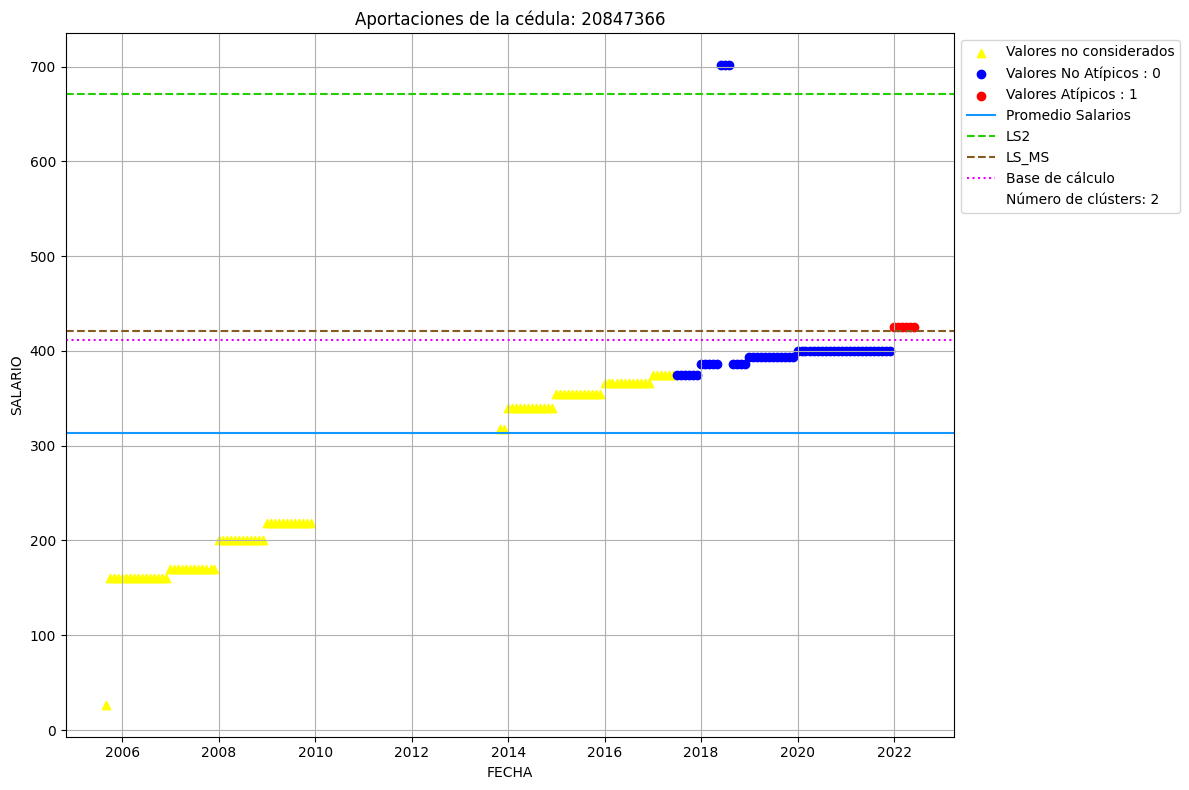

In [45]:
cedul =20847366
#graf_km(data_kmean , cedul, 'SALARIO',  grupo_sel = 0) #cedulas 271, 3057
graf_km_guardar(data_kmean , cedul, 'SALARIO',  grupo_sel = 0, caso=1)